<a href="https://colab.research.google.com/github/hlee014e/Projects/blob/main/Credit-Risk/Credit_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data from Kaggle**

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ranadeep_credit_risk_dataset_path = kagglehub.dataset_download('ranadeep/credit-risk-dataset')
#siddhantsindhkar_credit_risk_path = kagglehub.dataset_download('siddhantsindhkar/credit-risk')
#lorenzozoppelletto_financial_risk_for_loan_approval_path = kagglehub.dataset_download('lorenzozoppelletto/financial-risk-for-loan-approval')

print('Data source import complete.')


100%|██████████| 101M/101M [00:00<00:00, 113MB/s] 

Extracting files...


Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:


os.listdir(ranadeep_credit_risk_dataset_path)




['LCDataDictionary.xlsx', 'loan']

In [4]:


os.listdir(f"{ranadeep_credit_risk_dataset_path}/loan")


['loan.csv']

In [5]:
df = pd.read_csv(f"{ranadeep_credit_risk_dataset_path}/loan/loan.csv",
                 low_memory=False,
                 dtype={"desc": "string", "verification_status_joint": "string"})
print(df.head(2))


        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599     5000.0       5000.0           4975.0   36 months   
1  1077430    1314167     2500.0       2500.0           2500.0   60 months   

   int_rate  installment grade sub_grade  ... total_bal_il il_util  \
0     10.65       162.87     B        B2  ...          NaN     NaN   
1     15.27        59.83     C        C4  ...          NaN     NaN   

  open_rv_12m  open_rv_24m max_bal_bc all_util total_rev_hi_lim inq_fi  \
0         NaN          NaN        NaN      NaN              NaN    NaN   
1         NaN          NaN        NaN      NaN              NaN    NaN   

  total_cu_tl inq_last_12m  
0         NaN          NaN  
1         NaN          NaN  

[2 rows x 74 columns]


In [6]:
print(df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

In [7]:
print(df['desc'].head(3)) #description of the reason why they borrow the money

0      Borrower added on 12/22/11 > I need to upgra...
1      Borrower added on 12/22/11 > I plan to use t...
2                                                 <NA>
Name: desc, dtype: string


These are the necessary features that borrowers are required to fill in — i.e., the complete columns with no missing values.

In [27]:
n = len(df)

# Columns with zero missing values
complete = (
    missing_summary
    .query("missing_rate == 0")
    .assign(non_missing_count=n, non_missing_rate=1.0)
    .loc[:, ["non_missing_count", "non_missing_rate"]]
)

#print(f"{len(complete)} features are fully complete (no missing values).")
#print(complete)

# If you only want the names:
complete_cols = complete.index.tolist()
print("Complete columns:", complete_cols)

# Optional: save for your records
complete.to_csv("complete_features.csv")




Complete columns: ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'verification_status', 'home_ownership', 'issue_d', 'url', 'pymnt_plan', 'loan_status', 'addr_state', 'zip_code', 'dti', 'purpose', 'recoveries', 'total_rec_late_fee', 'last_pymnt_amnt', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_int', 'total_pymnt_inv', 'total_pymnt', 'out_prncp', 'out_prncp_inv', 'initial_list_status', 'revol_bal', 'application_type', 'policy_code']


Missing rates are high in these features, so we should take this into consideration. Sometimes, whether a value is missing or not can itself be important information.

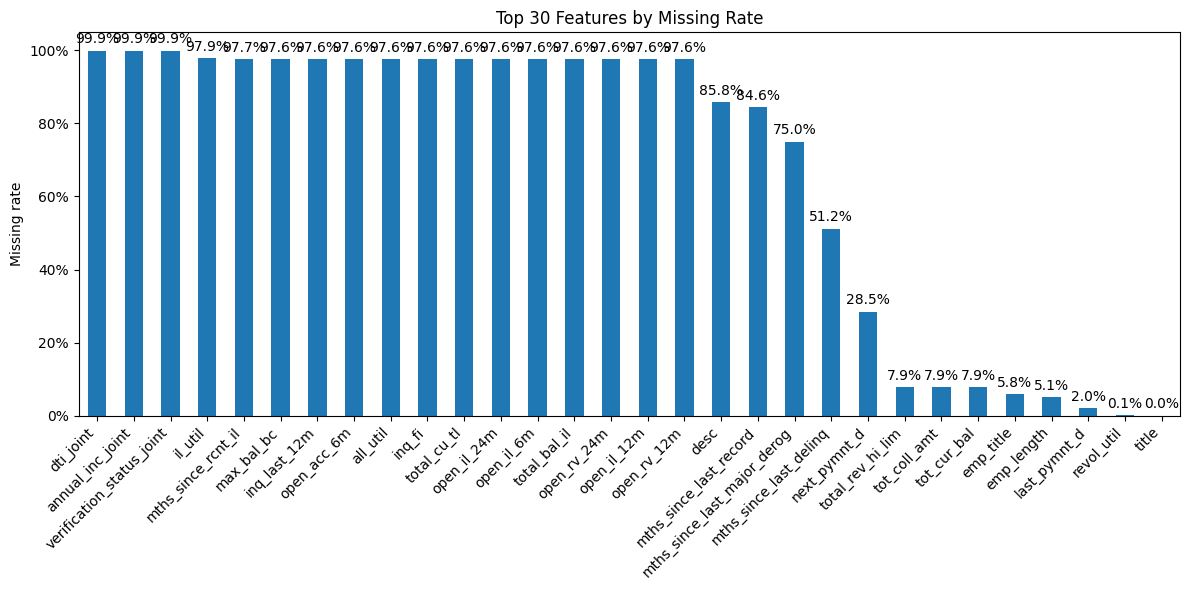

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

top_k = 30  # change as you like

top_missing = (
    missing_summary
    .sort_values("missing_rate", ascending=False)
    .head(top_k)
)

plt.figure(figsize=(12, 6))
ax = top_missing["missing_rate"].plot(kind="bar")
ax.set_title(f"Top {len(top_missing)} Features by Missing Rate")
ax.set_ylabel("Missing rate")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# optional: show percent labels above bars
for p, v in zip(ax.patches, top_missing["missing_rate"].values):
    ax.annotate(f"{v:.1%}", (p.get_x() + p.get_width()/2, p.get_height()),
                xytext=(0, 3), textcoords="offset points", ha="center", va="bottom")

plt.show()


Try to understand our target values

In [9]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [10]:
df['loan_status'].value_counts()

,count
loan_status,
Current,601779
Fully Paid,207723
Charged Off,45248
Late (31-120 days),11591
Issued,8460
In Grace Period,6253
Late (16-30 days),2357
Does not meet the credit policy. Status:Fully Paid,1988
Default,1219


In [11]:
df['open_acc_6m'].value_counts()

,count
open_acc_6m,
0.0,8246
1.0,6808
2.0,3752
3.0,1572
4.0,593
5.0,232
6.0,104
7.0,37
8.0,13


In [12]:
df['dti'].value_counts()

,count
dti,
19.20,684
14.40,674
18.00,661
13.20,638
16.80,632
...,...
54.36,1
48.91,1
45.77,1


In [13]:
df['dti'].isna().sum() #in other words, no missing value on dti=monthly_debt/monthly_income

np.int64(0)

# Binning Strategy: Numeric vs. Non-Numeric Features

We bin features differently depending on their data type:

- **Numeric features** (e.g., `int_rate`, `dti`, `tot_cur_bal`):  
  Use quantile or equal-width bins to group continuous values, plus a dedicated **Missing** bin.  
  This stabilizes **WOE/IV** estimates and reduces noise/outlier sensitivity.

- **Non-numeric (categorical) features** (e.g., `emp_title`, `purpose`):  
  Group categories by frequency, cap rare categories into **"Other"**, and keep a **Missing** bin.  
  This prevents high cardinality features from overfitting and keeps WOE/IV well-behaved.

**Why bin at all?**  
- Produces smoother, more monotone relationships with the target for credit-risk style models.  
- Improves interpretability (scorecards) and robustness to outliers.  
- Reduces variance in small samples within a bin/category.


In [14]:
import pandas as pd
import numpy as np

# ---------- 1) Define target (adjust to your labels) ----------
# Example mapping for LendingClub-style data:
BAD_LABELS = {'Charged Off','Default','Late (31-120 days)'}
GOOD_LABELS = {'Fully Paid'}
# Everything else will be ignored or treated as "other" (you can customize)

def map_loan_status(x):
    if x in BAD_LABELS: return 1
    if x in GOOD_LABELS: return 0
    return np.nan  # drop unknown statuses for IV calc

df = df.copy()
df['target_bad'] = df['loan_status'].map(map_loan_status)
df = df.dropna(subset=['target_bad']).reset_index(drop=True)
df['target_bad'] = df['target_bad'].astype(int)

# ---------- 2) Columns to ignore (IDs, clear leakage/post-origination) ----------
IGNORE = {
    'id','member_id','loan_status','target_bad',
    'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
    'total_rec_prncp','total_rec_int','total_rec_late_fee',
    'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
    'next_pymnt_d','last_credit_pull_d','pymnt_plan','url','desc','title','zip_code','sub_grade'
}

# --- Adjust if needed ---
TARGET = 'target_bad'
IGNORE = {
    'id','member_id','loan_status','target_bad',
    'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
    'total_rec_prncp','total_rec_int','total_rec_late_fee',
    'recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
    'next_pymnt_d','last_credit_pull_d','pymnt_plan','url','desc','title','zip_code','sub_grade'
}

def decide_binner(s: pd.Series):
    """Return ('NUMERIC'|'CATEGORICAL', reason_string)."""
    if pd.api.types.is_numeric_dtype(s):
        return 'NUMERIC', f"numeric dtype: {s.dtype}"
    # object/string but maybe numeric-looking (e.g., '12.3', '45%')
    # try a gentle coercion check
    s_str = s.astype('string')
    coerced = pd.to_numeric(s_str.str.replace('%','', regex=False), errors='coerce')
    frac_numeric = coerced.notna().mean() if len(s_str) else 0.0
    if frac_numeric > 0.95:
        return 'CATEGORICAL*', f"object dtype but ~{frac_numeric:.0%} numeric-looking; consider cleaning"
    return 'CATEGORICAL', f"non-numeric dtype: {s.dtype}"

rows = []
for col in df.columns:
    if col in IGNORE:
        continue
    s = df[col]
    kind, reason = decide_binner(s)
    nmiss = s.isna().sum()
    nunique = s.nunique(dropna=True)
    rows.append({
        'feature': col,
        'dtype': str(s.dtype),
        'chooser': kind,                # what will be used
        'n_unique_nonmiss': int(nunique),
        'n_missing': int(nmiss),
        'note': reason
    })

use_table = pd.DataFrame(rows).sort_values(['chooser','feature']).reset_index(drop=True)

# Split views
used_numeric = use_table[use_table['chooser'] == 'NUMERIC'].copy()
used_categ  = use_table[use_table['chooser'].isin(['CATEGORICAL','CATEGORICAL*'])].copy()

print("=== NUMERIC → _bin_numeric_with_missing ===")
display(used_numeric[['feature','dtype','n_unique_nonmiss','n_missing','note']])

print("\n=== CATEGORICAL → _bin_categorical_with_missing ===")
display(used_categ[['feature','dtype','n_unique_nonmiss','n_missing','note']])

# Optional: save the report
use_table.to_csv("binning_routing_report.csv", index=False)


=== NUMERIC → _bin_numeric_with_missing ===


,feature,dtype,n_unique_nonmiss,n_missing,note
13,acc_now_delinq,float64,6,0,numeric dtype: float64
14,all_util,float64,126,265637,numeric dtype: float64
15,annual_inc,float64,20264,0,numeric dtype: float64
16,annual_inc_joint,float64,3,265778,numeric dtype: float64
17,collections_12_mths_ex_med,float64,7,56,numeric dtype: float64
18,delinq_2yrs,float64,24,0,numeric dtype: float64
19,dti,float64,3990,0,numeric dtype: float64
20,dti_joint,float64,3,265778,numeric dtype: float64
21,funded_amnt,float64,1334,0,numeric dtype: float64
22,funded_amnt_inv,float64,8536,0,numeric dtype: float64



=== CATEGORICAL → _bin_categorical_with_missing ===


,feature,dtype,n_unique_nonmiss,n_missing,note
0,addr_state,object,51,0,non-numeric dtype: object
1,application_type,object,2,0,non-numeric dtype: object
2,earliest_cr_line,object,647,0,non-numeric dtype: object
3,emp_length,object,11,10687,non-numeric dtype: object
4,emp_title,object,137032,14799,non-numeric dtype: object
5,grade,object,7,0,non-numeric dtype: object
6,home_ownership,object,6,0,non-numeric dtype: object
7,initial_list_status,object,2,0,non-numeric dtype: object
8,issue_d,object,103,0,non-numeric dtype: object
9,purpose,object,14,0,non-numeric dtype: object


In [15]:

#

# ---------- 3) IV / WOE utilities ----------
EPS = 1e-6  # smoothing to avoid div-by-zero / log(0)

def _bin_numeric_with_missing(s: pd.Series, bins):
    """
    Quantile-bin numeric features on their REAL values (not ranks),
    keep NaNs as 'MISSING', and return a categorical Series of the same length.
    Guarantees each row belongs to exactly one bin or 'MISSING'.
    """
    s = s.copy()
    mask = s.notna() #not missing values
    n_nonmiss = int(mask.sum())

    # If everything is missing → return all 'MISSING'
    if n_nonmiss == 0:
        return pd.Series(['MISSING'] * len(s), index=s.index, dtype="object")

    # How many distinct non-missing values do we have?
    uniq = s[mask].nunique(dropna=True)
    nbins = max(1, min(int(bins), int(uniq)))  # can't have more bins than number of unique values

    # Try quantile binning on REAL values
    binned = None
    try:
        # duplicates='drop' lets qcut reduce the bin count if quantile edges coincide
        binned = pd.qcut(s[mask], q=nbins, duplicates='drop')
    except Exception:
        # Fallback 1: try fewer bins
        tried = False
        for q in range(min(nbins, 10), 1, -1):
            try:
                binned = pd.qcut(s[mask], q=q, duplicates='drop')
                tried = True
                break
            except Exception:
                continue
        # Fallback 2: equal-width bins if even quantiles failed
        if not tried or binned is None:
            try:
                binned = pd.cut(s[mask], bins=min(nbins, 10))
            except Exception:
                # Last resort: put all non-missing into one bucket
                binned = pd.Series(['BIN_ALL'] * n_nonmiss, index=s[mask].index, dtype="object")

    # Build output: non-missing get their bin label; missing → 'MISSING'
    out = pd.Series(index=s.index, dtype="object")
    out[mask] = binned.astype(str)
    out[~mask] = 'MISSING'

    return out




def _bin_categorical_with_missing(s: pd.Series, max_levels=50):
    """Use categories directly; collapse rare levels; keep NaN as 'MISSING'."""
    s = s.astype('string')
    s = s.fillna('MISSING')
    # collapse rare levels if too many categories
    vc = s.value_counts(dropna=False)
       #nan values를 드랍하지 않음. 즉 고려함.
    if len(vc) > max_levels:
        keep = set(vc.nlargest(max_levels - 1).index)  # leave 1 slot for 'OTHER'
        s = s.where(s.isin(keep), other='OTHER')
    return s
    #빈도수가 많은것들 50개만 킵하고 나머지는 다 'Other'로.

def woe_iv_for_binned(bins: pd.Series, y: pd.Series) -> pd.DataFrame:
    """Compute WOE/IV per bin + total IV."""
    g = (
        pd.DataFrame({'bin': bins, 'y': y})
        .groupby('bin', dropna=False)['y']
        .agg(event='sum', total='count')
        .reset_index()
    ) #y is a target values. y=1: event happens: Bad event, in other words, as defaulted(get loan but didnt pay it)
    g['non_event'] = g['total'] - g['event']
    # distributions
    total_event = g['event'].sum()
    total_nonevent = g['non_event'].sum()
    g['dist_event'] = (g['event'] + EPS) / (total_event + 2*EPS)
    g['dist_nonevent'] = (g['non_event'] + EPS) / (total_nonevent + 2*EPS)
    #EPS;epsilon^^ since we want 'no division by zero', EPS is already defined above.
    # woe & iv
    g['woe'] = np.log(g['dist_event'] / g['dist_nonevent'])
    #Weight of Evidence
    g['iv']  = (g['dist_event'] - g['dist_nonevent']) * g['woe']
    #information Value, which is always positive by definition. >=0.3 Strong
    g = g.sort_values('woe').reset_index(drop=True)
    g.attrs['iv_total'] = float(g['iv'].sum())
    return g

def calc_iv(df: pd.DataFrame, feature: str, target: str, bins=10, max_levels=50):
    s = df[feature]
    if pd.api.types.is_numeric_dtype(s):
        b = _bin_numeric_with_missing(s, bins=bins)
    else:
        b = _bin_categorical_with_missing(s, max_levels=max_levels)
    return woe_iv_for_binned(b, df[target])

# ---------- 4) Run IV over all features ----------
iv_results = {}
woe_tables = {}   # keep detailed tables if you want to inspect later

for col in df.columns:
    if col in IGNORE:
        continue
    try:
        wt = calc_iv(df, col, 'target_bad', bins=10, max_levels=50)
        iv_total = wt.attrs['iv_total']
        iv_results[col] = iv_total
        woe_tables[col] = wt
    except Exception as e:
        # some columns (e.g., all-NaN) will fail gracefully
        pass

iv_sorted = pd.Series(iv_results).sort_values(ascending=False)
iv_sorted.head(40)


,0
int_rate,0.408890
grade,0.401221
term,0.151475
dti,0.103149
issue_d,0.083972
tot_cur_bal,0.074537
revol_util,0.064370
total_rev_hi_lim,0.060932
annual_inc,0.048269
verification_status,0.044882


In [16]:
df['purpose'].value_counts()


,count
purpose,
debt_consolidation,156572
credit_card,52405
home_improvement,15638
other,14937
major_purchase,6486
small_business,4955
car,3726
medical,2994
moving,2129


In [17]:
import pandas as pd

# 1) Keep rows with target present
df2 = df[df['target_bad'].notna()].copy()

# 2) Bin 'purpose' as categorical (cap to Top-49 + OTHER + MISSING = ~50 levels)
b = _bin_categorical_with_missing(df2['purpose'], max_levels=50)

# 3) Compute WOE/IV table
tbl = woe_iv_for_binned(b, df2['target_bad']).copy()
tbl['event_rate'] = tbl['event'] / tbl['total']

# 4) Nice ordering for inspection (most data first)
tbl_sorted = tbl.sort_values(['total','event_rate'], ascending=[False, False]).reset_index(drop=True)

# 5) Show key columns
print(tbl_sorted[['bin','event','non_event','total','event_rate']])

# 6) IV total + sanity check
iv_total = float(tbl_sorted['iv'].sum())
print("\nIV_total (purpose):", iv_total)
print("Sum totals:", int(tbl_sorted['total'].sum()), " vs rows:", len(df2))




                   bin  event  non_event   total  event_rate
0   debt_consolidation  35808     120764  156572    0.228700
1          credit_card  10155      42250   52405    0.193779
2     home_improvement   2978      12660   15638    0.190434
3                other   3596      11341   14937    0.240744
4       major_purchase   1095       5391    6486    0.168825
5       small_business   1580       3375    4955    0.318870
6                  car    528       3198    3726    0.141707
7              medical    709       2285    2994    0.236807
8               moving    526       1603    2129    0.247064
9              wedding    273       1690    1963    0.139073
10               house    354       1366    1720    0.205814
11            vacation    337       1318    1655    0.203625
12         educational     56        269     325    0.172308
13    renewable_energy     63        213     276    0.228261

IV_total (purpose): 0.022626925537373457
Sum totals: 265781  vs rows: 265781


In [18]:
#tot_coll_amt=total collection ammount(#이렇게 자르는게 맞나 빈 구간을)

#int_rate iv and woe
df2 = df[df['target_bad'].notna()].copy()      # you can also reset_index(drop=True)

b = _bin_numeric_with_missing(df2['tot_coll_amt'], bins=10)
tbl = woe_iv_for_binned(b, df2['target_bad'])
tbl['event_rate'] = tbl['event'] / tbl['total']

print(tbl[['bin','event','non_event','total','event_rate']])
print("Sum totals:", tbl['total'].sum(), " vs rows:", len(df2))

                 bin  event  non_event   total  event_rate
0            MISSING  10158      53689   63847    0.159099
1     (-0.001, 82.0]  42732     139045  181777    0.235079
2  (82.0, 9152545.0]   5168      14989   20157    0.256387
Sum totals: 265781  vs rows: 265781


In [19]:
#delinq_2yrs=delinquencies(more than 30 days) in 2 years
df2 = df[df['target_bad'].notna()].copy()      # you can also reset_index(drop=True)

b = _bin_numeric_with_missing(df2['delinq_2yrs'], bins=10)
tbl = woe_iv_for_binned(b, df2['target_bad'])
tbl['event_rate'] = tbl['event'] / tbl['total']

print(tbl[['bin','event','non_event','total','event_rate']])
print("Sum totals:", tbl['total'].sum(), " vs rows:", len(df2))

             bin  event  non_event   total  event_rate
0  (-0.001, 1.0]  54409     197726  252135    0.215793
1    (1.0, 29.0]   3649       9997   13646    0.267404
Sum totals: 265781  vs rows: 265781


In [20]:
!pip install xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 3.9 MB/s eta 0:00:00


In [21]:
import pandas as pd
import numpy as np

# Keep only rows with target present
df2 = df[df['target_bad'].notna()].copy()

features = [
    'int_rate','dti','tot_cur_bal','revol_util','total_rev_hi_lim','annual_inc',
    'tot_coll_amt','funded_amnt','open_il_12m','inq_fi','open_acc_6m','total_cu_tl',
    'open_rv_12m','open_il_24m','open_il_6m','inq_last_12m','total_bal_il','max_bal_bc',
    'all_util','inq_last_6mths','mths_since_rcnt_il','il_util',
    'mths_since_last_major_derog','mths_since_last_delinq','total_acc','delinq_2yrs',
    'open_acc','mths_since_last_record','pub_rec','collections_12_mths_ex_med',
    'policy_code','acc_now_delinq'
]

all_rows = []
for feat in features:
    if feat not in df2.columns:
        print(f"[skip] {feat}: not in df")
        continue
    s = df2[feat]
    try:
        # binning
        if pd.api.types.is_numeric_dtype(s):
            b = _bin_numeric_with_missing(s, bins=10) #I made bins=10
        else:
            b = _bin_categorical_with_missing(s, max_levels=50)

        tbl = woe_iv_for_binned(b, df2['target_bad'])
        tbl['event_rate'] = tbl['event'] / tbl['total']

        # add feature name
        tbl.insert(0, 'feature', feat)

        # keep main columns
        out = tbl[['feature','bin','event','non_event','total','event_rate']].copy()

        # append to big list
        all_rows.append(out)

        # add an empty row (NaNs) for spacing
        all_rows.append(pd.DataFrame(
            [[feat, None, None, None, None, None]],
            columns=['feature','bin','event','non_event','total','event_rate']
        ))

    except Exception as e:
        print(f"[error] {feat}: {e}")

# concatenate
ALL = pd.concat(all_rows, ignore_index=True)

# save Excel (one sheet)
excel_path = "woe_iv_all_in_one_spaced.xlsx"
with pd.ExcelWriter(excel_path, engine="openpyxl") as writer:
    ALL.to_excel(writer, sheet_name="ALL", index=False)

# 👉 save CSV as well
csv_path = "woe_iv_all_in_one_spaced.csv"
ALL.to_csv(csv_path, index=False)

print("Saved ->", excel_path)
print("Saved ->", csv_path)



/tmp/ipython-input-2878165780.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ALL = pd.concat(all_rows, ignore_index=True)


Saved -> woe_iv_all_in_one_spaced.xlsx
Saved -> woe_iv_all_in_one_spaced.csv


In [22]:
!ls -lh


total 40K
-rw-r--r-- 1 root root 3.2K Oct  7 18:21 binning_routing_report.csv
drwxr-xr-x 1 root root 4.0K Oct  6 13:38 sample_data
-rw-r--r-- 1 root root  14K Oct  7 18:22 woe_iv_all_in_one_spaced.csv
-rw-r--r-- 1 root root  16K Oct  7 18:22 woe_iv_all_in_one_spaced.xlsx


In [23]:
#Save it into google drive not to loose any datas
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# --- inputs you already have ---
# df: your dataframe
# iv_sorted: pd.Series mapping feature -> IV (descending)
# IGNORE: set of columns to ignore
TARGET = 'target_bad'  # adjust if you used a different name
THRESH = 0.8         # correlation threshold

# 1) choose candidate numeric features
candidates = [
    c for c in df.columns
    if c not in IGNORE and c != TARGET and pd.api.types.is_numeric_dtype(df[c])
]

# 2) correlation matrix (absolute), only over candidates
corr = df[candidates].corr(numeric_only=True).abs()

# 3) ensure we have IV values for all candidates (default 0.0 if missing)
iv_map = iv_sorted.to_dict()
for c in candidates:
    if c not in iv_map:
        iv_map[c] = 0.0

# 4) sort candidates by IV descending (higher IV first → kept preferentially)
ordered = sorted(candidates, key=lambda c: iv_map.get(c, 0.0), reverse=True)

# 5) greedy selection: keep feature if it's not >THRESH correlated with any kept feature
kept = []
dropped = {}  # feature -> reason (conflicts with which kept feature)

for col in ordered:
    # skip columns that are all-NaN in corr
    if col not in corr.columns:
        continue
    # check correlation vs already kept
    too_correlated_with = None
    for k in kept:
        # if either column is missing from corr (rare), skip safely
        if col in corr.index and k in corr.columns:
            if corr.loc[col, k] > THRESH:
                too_correlated_with = k
                break
    if too_correlated_with is None:
        kept.append(col)
    else:
        dropped[col] = f"corr({col}, {too_correlated_with}) = {corr.loc[col, too_correlated_with]:.2f} > {THRESH}"

print(f"Kept ({len(kept)}):", kept)
print(f"Dropped ({len(dropped)}):")
for c, reason in dropped.items():
    print(f"  - {c}: {reason}")

# Optionally build a reduced dataframe
df_reduced = df.drop(columns=list(dropped.keys()), errors='ignore')
print("Original shape:", df.shape, "→ Reduced shape:", df_reduced.shape)


In [ ]:
# ===== AFTER your pruning block =====
# Assumes: df, kept, TARGET, THRESH, and your IV/WOE helpers (calc_iv, etc.) already exist.


import matplotlib.pyplot as plt
import seaborn as sns

# 1) Recompute IV for kept features
kept_iv = {}
kept_woe_tables = {}

for col in kept:
    if col not in df.columns:
        continue
    try:
        wt = calc_iv(df, col, TARGET, bins=10, max_levels=50)
        kept_iv[col] = wt.attrs.get('iv_total', float(wt['iv'].sum()))
        kept_woe_tables[col] = wt
    except Exception as e:
        # Skip columns that fail (e.g., all-NaN), or print if you want
        # print(f"IV failed for {col}: {e}")
        pass

iv_kept_df = (
    pd.Series(kept_iv, name='IV')
    .to_frame()
    .sort_values('IV', ascending=False)
)
print("=== Kept features with IV (sorted) ===")
print(iv_kept_df)

# 2) Save IV table
iv_kept_df.to_csv('kept_features_iv.csv', index=True)
print("Saved IV table to kept_features_iv.csv")

# 3) Correlation heatmap among kept features, showing only > THRESH
kept_numeric = [c for c in kept if pd.api.types.is_numeric_dtype(df[c])]
corr_kept = df[kept_numeric].corr(numeric_only=True).abs()

# mask correlations <= THRESH to declutter the plot
corr_masked = corr_kept.mask(corr_kept <= THRESH)

plt.figure(figsize=(18, 14))
sns.heatmap(
    corr_masked,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": .8}
)
plt.title(f"Correlation Heatmap Among Kept Features (only > {THRESH} shown)")
plt.show()

# 4) Optional: Top-N bar chart of kept features by IV
topN = 20
ax = iv_kept_df.head(topN).plot(kind='barh', figsize=(8, 10))
ax.invert_yaxis()
ax.set_title(f'Top {topN} Kept Features by IV')
ax.set_xlabel('Information Value')
ax.set_ylabel('Feature')
plt.show()

# 5) (Optional) Peek a specific WOE table, e.g. 'annual_inc'
# kept_woe_tables['annual_inc']


In [ ]:
print(kept)

In [ ]:
pip install xgboost scikit-learn


In [ ]:
from sklearn.model_selection import train_test_split

# Features you kept
features = kept   # the list you built with correlation pruning
TARGET = 'target_bad'

X = df[features]
y = df[TARGET]

# Split into train and test sets (80/20 split)



In [ ]:
print(X.shape)

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    eval_metric="auc",
    random_state=42
)
model.fit(X_train, y_train)

pred = model.predict_proba(X_valid)[:,1]
print("Validation AUC:", roc_auc_score(y_valid, pred))


In [ ]:
# 1) Install & imports (once per session)
!pip -q install shap
import numpy as np
import shap
import matplotlib.pyplot as plt


In [ ]:
# 2) Compute SHAP values for the validation set
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_valid)   # SHAP in log-odds; Explanation object


In [ ]:
# 3) Waterfall plot for the FIRST row (row 0)
row_idx = 3
shap.plots.waterfall(shap_values[row_idx], max_display=15)
print('default or not:',y[3])


In [ ]:
import numpy as np

# counts
n_good = (y == 0).sum()   # non-defaults
n_bad  = (y == 1).sum()   # defaults

# baseline probability of default
p_default = n_bad / (n_good + n_bad)
p_good = n_good / (n_good + n_bad)

# baseline log-odds (what XGBoost uses as base_value)
baseline_log_odds = np.log(p_default / p_good)

print(f"Total samples: {n_good + n_bad}")
print(f"Non-default (y=0): {n_good}")
print(f"Default     (y=1): {n_bad}")
print(f"Baseline probability of default: {p_default:.4f}")
print(f"Baseline log-odds: {baseline_log_odds:.4f}")


In [ ]:
# 0) Make sure SHAP was computed on X_valid (not df)
#    If you already ran this earlier, you can skip.
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_valid)   # <-- SHAP is now for X_valid rows

# 1) See the *features actually fed to the model* for rows 0..10
Xv_0_10 = X_valid.reset_index(drop=True).iloc[0:11]
display(Xv_0_10)  # or print(Xv_0_10)

# 2) See the *original df rows* that correspond to those validation rows
#    (use the original indices preserved in X_valid.index)
orig_rows_0_10 = df.loc[X_valid.index[0:11]]
display(orig_rows_0_10)  # full raw data slice from the original df

# 3) Confirm SHAP is for these exact rows & print a concise per-row summary
import numpy as np
import pandas as pd

# predicted probabilities for these same rows
probs_0_10 = model.predict_proba(X_valid.iloc[0:11])[:, 1]
true_0_10  = y_valid.iloc[0:11].values

# build a small table with top-3 SHAP features per row
if hasattr(X_valid, "columns"):
    feature_names = np.array(X_valid.columns)
else:
    feature_names = np.array([f"f{i}" for i in range(X_valid.shape[1])])

rows = []
for row_idx in range(11):
    vals = shap_values.values[row_idx]  # SHAP for this X_valid row (log-odds)
    top = np.argsort(np.abs(vals))[::-1][:3]
    rows.append({
        "row_idx_in_valid": row_idx,
        "orig_df_index": X_valid.index[row_idx],
        "true_label": int(true_0_10[row_idx]),
        "pred_prob_bad": float(probs_0_10[row_idx]),
        "top1": f"{feature_names[top[0]]}: {vals[top[0]]:+.4f}",
        "top2": f"{feature_names[top[1]]}: {vals[top[1]]:+.4f}",
        "top3": f"{feature_names[top[2]]}: {vals[top[2]]:+.4f}",
    })

summary = pd.DataFrame(rows)
display(summary)



In [ ]:
from xgboost import plot_tree, to_graphviz


In [ ]:
model = xgb.XGBClassifier(
    n_estimators=2,
    learning_rate=1,
    max_depth=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="auc"
)
model.fit(X_train, y_train)

# Tree 0
dot0 = to_graphviz(model, tree_idx=0, rankdir="LR")
dot0.render("xgb_tree0", format="pdf")

# Tree 1
dot1 = to_graphviz(model, tree_idx=1, rankdir="LR")
dot1.render("xgb_tree1", format="pdf")
from google.colab import files
files.download("xgb_tree0.pdf")
files.download("xgb_tree1.pdf")



In [ ]:
from google.colab import files
files.download("xgb_tree0.pdf")
files.download("xgb_tree1.pdf")